# Nama Project : Memprediksi Outcome (Alive or Dead) Akibat Penyakit Diabetes Berdasarkan Dataset "diabetes-vid.csv" menggunakan Algoritma Learning Vector Quantization (LVQ)

## Library yang Digunakan

In [32]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from google.colab import files
from sklearn.model_selection import train_test_split

## Untuk Upload File(csv)

In [33]:
uploaded=files.upload()

Saving Obesity Classification.csv to Obesity Classification (1).csv


## Menampilkan Dataset

In [34]:
dataset = pd.read_csv('Obesity Classification.csv')
dataset.head(10)

,ID,Age,Gender,Height,Weight,BMI,Label
0,1,25,Male,175,80,25.3,Normal Weight
1,2,30,Female,160,60,22.5,Normal Weight
2,3,35,Male,180,90,27.3,Overweight
3,4,40,Female,150,50,20.0,Underweight
4,5,45,Male,190,100,31.2,Obese
5,6,50,Female,140,40,16.7,Underweight
6,7,55,Male,200,110,34.2,Obese
7,8,60,Female,130,30,13.3,Underweight
8,9,65,Male,210,120,37.2,Obese
9,10,70,Female,120,20,10.0,Underweight


In [35]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      108 non-null    int64  
 1   Age     108 non-null    int64  
 2   Gender  108 non-null    object 
 3   Height  108 non-null    int64  
 4   Weight  108 non-null    int64  
 5   BMI     108 non-null    float64
 6   Label   108 non-null    object 
dtypes: float64(1), int64(4), object(2)
memory usage: 6.0+ KB


In [36]:
dataset.empty

False

## Merubah Tipe Data Object ke Integer

In [37]:
en = LabelEncoder()
dataset['Gender'] = en.fit_transform(dataset['Gender'])
dataset['Label'] = en.fit_transform(dataset['Label'])
dataset.head(10)

,ID,Age,Gender,Height,Weight,BMI,Label
0,1,25,1,175,80,25.3,0
1,2,30,0,160,60,22.5,0
2,3,35,1,180,90,27.3,2
3,4,40,0,150,50,20.0,3
4,5,45,1,190,100,31.2,1
5,6,50,0,140,40,16.7,3
6,7,55,1,200,110,34.2,1
7,8,60,0,130,30,13.3,3
8,9,65,1,210,120,37.2,1
9,10,70,0,120,20,10.0,3


In [38]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      108 non-null    int64  
 1   Age     108 non-null    int64  
 2   Gender  108 non-null    int64  
 3   Height  108 non-null    int64  
 4   Weight  108 non-null    int64  
 5   BMI     108 non-null    float64
 6   Label   108 non-null    int64  
dtypes: float64(1), int64(6)
memory usage: 6.0 KB


## Visualisasi Data

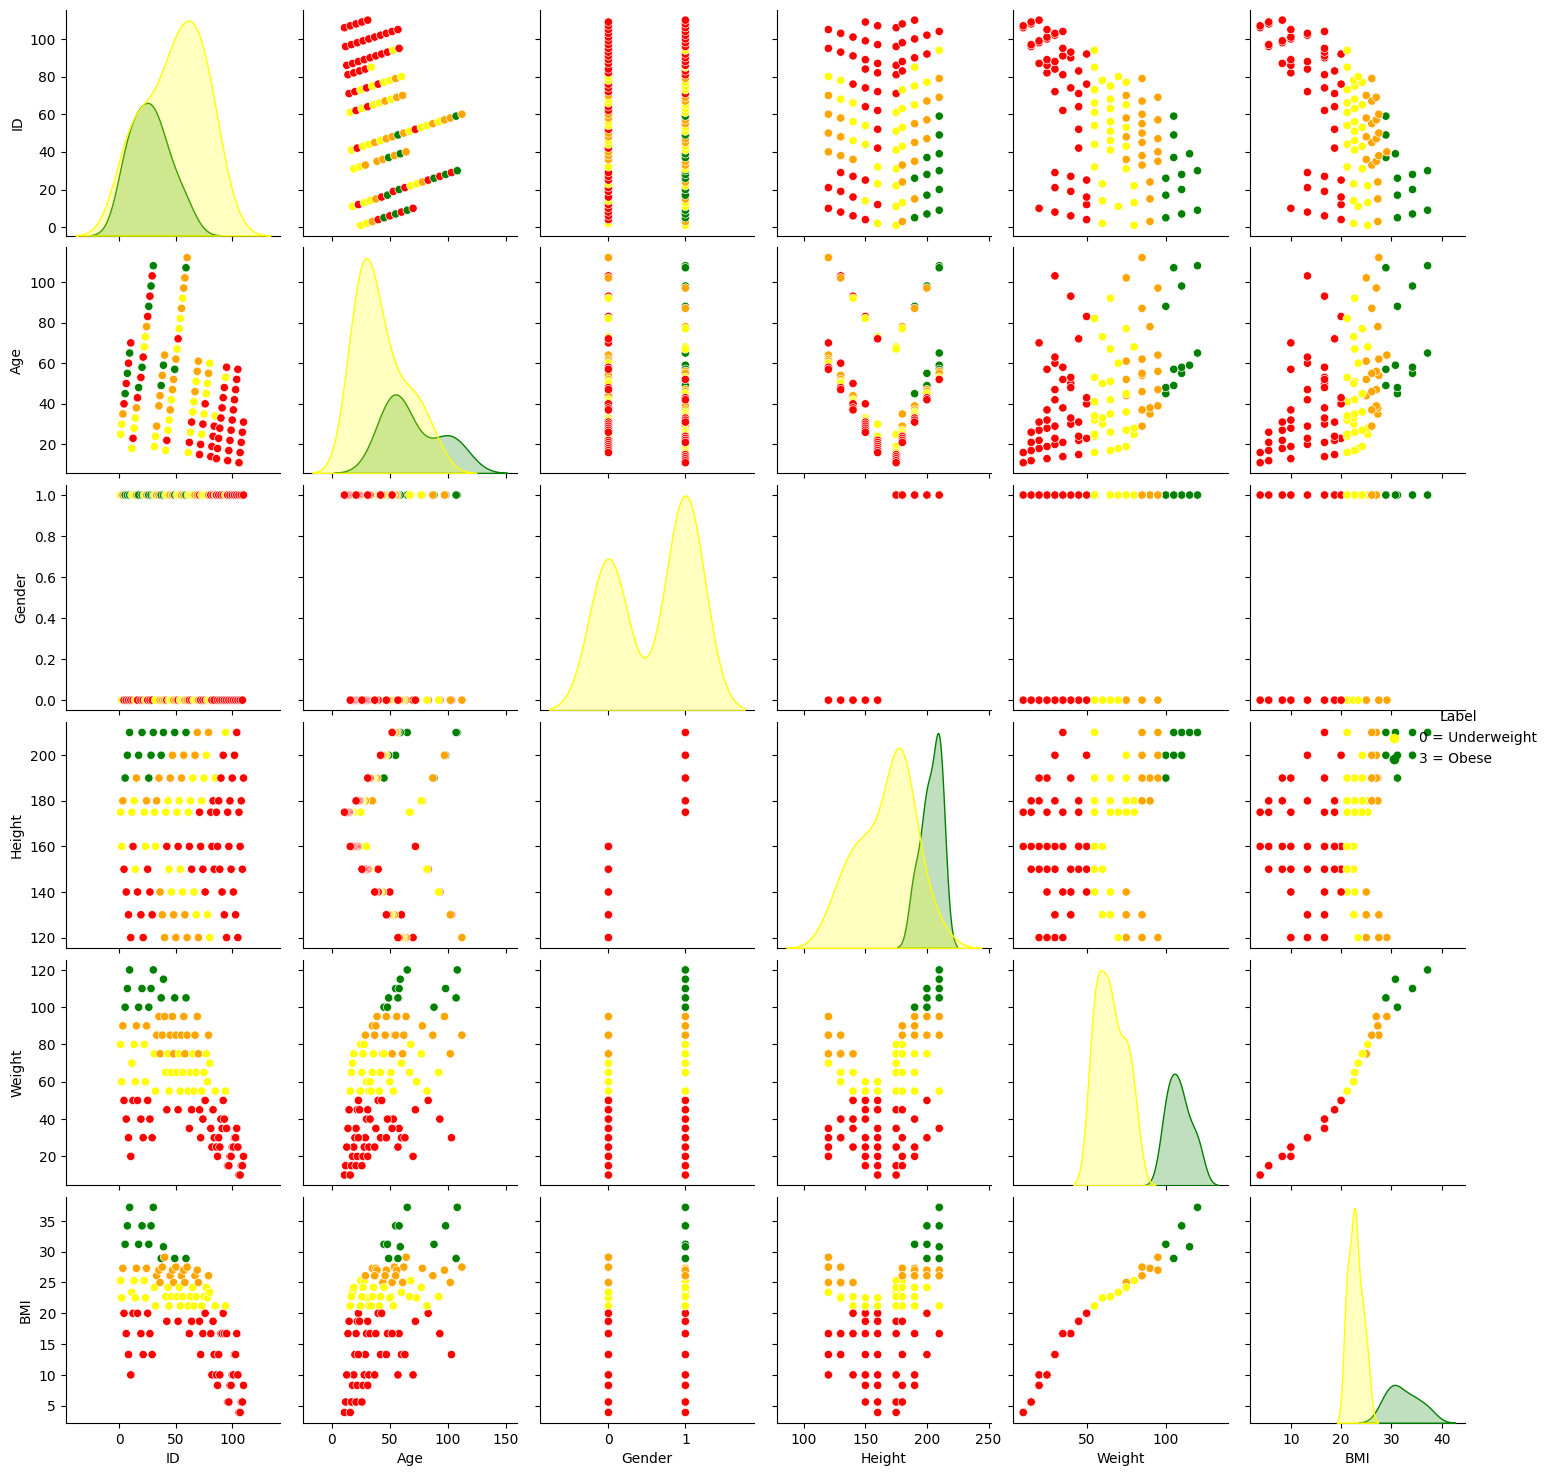

In [39]:
plot = sns.pairplot(dataset, hue="Label", hue_order=[0, 1], palette={0: 'yellow', 1: 'green', 2: 'orange', 3: 'red'})

plot._legend.set_title('Label')
plot._legend.texts[0].set_text('0 = Underweight')
plot._legend.texts[1].set_text('1 = Normal weight')
plot._legend.texts[1].set_text('2 = Overweight')
plot._legend.texts[1].set_text('3 = Obese')

plt.show()

In [40]:
features = dataset[['Age',	'Gender', 'Height',	'Weight',	'BMI']].values
labels = dataset[['Label']].values.reshape(-1)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=42)

## Learning Vector Quantization

In [42]:
def euclidian(fvec, alpha):
    prototypes, proto_labels = alpha
    # Compute distance from each prototype to this point
    distances = list(np.sum(np.subtract(fvec, p)**2) for p in prototypes)
    min_dist_index = distances.index(min(distances))

    # Determine winner prototype.
    winner = prototypes[min_dist_index]
    winner_label = proto_labels[min_dist_index]

    return winner, winner_label, min_dist_index

In [43]:
def init_prototype(data, labels):
    labels = labels.astype(int)
    unique_labels = list(set(labels))

    prototypes = np.empty((len(unique_labels), data.shape[1]))
    proto_labels = []

    # Initialize prototypes using class means.
    for i in unique_labels:
        class_data = data[labels == i, :]

        # Compute class mean.
        mean = np.mean(class_data, axis=0)

        prototypes[i] = mean
        proto_labels.append(i)

    return prototypes, proto_labels

In [44]:
def lvq(alpha, X, y, learning_rate):
    prototypes, proto_labels = alpha
    winner, winner_label, min_dist_index = euclidian(X, alpha)

    #Push or repel the prototype based on the label.
    sign = 1 if winner_label == y else -1

    # Update winner prototype
    prototypes[min_dist_index] = np.add(prototypes[min_dist_index], np.subtract(X, winner) * learning_rate * sign)

    return prototypes

In [45]:
def validate(X, y, val_err, alpha):
    winner, winner_label, min_dist_index = euclidian(X, alpha)

    # Check if labels match
    if not winner_label == y:
        val_err = val_err + 1

    return val_err

In [46]:
def train_lvq(data, labels, num_epochs, learning_rate, validation_data=None, validation_labels=None):
    # Get init values
    prototypes, proto_labels = init_prototype(data, labels)

    # Loop through data set.
    for epoch in range(0, num_epochs):
        for X, y in zip(data, labels):
            alpha = prototypes, proto_labels
            prototypes = lvq(alpha, X, y, learning_rate)

        # Use validation set to test performance.
        val_err = 0
        if validation_labels is not None:
            for X, y in zip(validation_data, validation_labels):
                alpha = prototypes, proto_labels
                val_err = validate(X, y, val_err, alpha)

            val_err = val_err / len(validation_labels)
            print("Epoch " + str(epoch) + ". Validation error: " + str(val_err))
        else:
            print("Epoch " + str(epoch))


    return (prototypes, proto_labels)

In [47]:
alpha = train_lvq(X_train, y_train, 10, 0.1, validation_data=X_test, validation_labels=y_test)

Epoch 0. Validation error: 0.2777777777777778
Epoch 1. Validation error: 0.2777777777777778
Epoch 2. Validation error: 0.2777777777777778
Epoch 3. Validation error: 0.3055555555555556
Epoch 4. Validation error: 0.2777777777777778
Epoch 5. Validation error: 0.2777777777777778
Epoch 6. Validation error: 0.2777777777777778
Epoch 7. Validation error: 0.2777777777777778
Epoch 8. Validation error: 0.2777777777777778
Epoch 9. Validation error: 0.2777777777777778


## Analyze Trained Prototype

In [48]:
def get_accuracy(X, y, alpha):
    wrong = 0
    for i, x in enumerate(X):
        wrong = validate(x, y[i], wrong, alpha)

    accuracy = 1 - wrong / len(X)
    return accuracy

## Menampilkan Tingkat Akurasi

In [49]:
test_accuracy = get_accuracy(X_test, y_test, alpha)
print("Train accuracy: {0:1.3f}".format(test_accuracy))

Train accuracy: 0.722


In [50]:
akurasi = get_accuracy(X_test, y_test, alpha)
print("Tingkat Akurasi : %d persen"%(akurasi*100))

Tingkat Akurasi : 72 persen
